# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [3]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [6]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [4]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [5]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [6]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

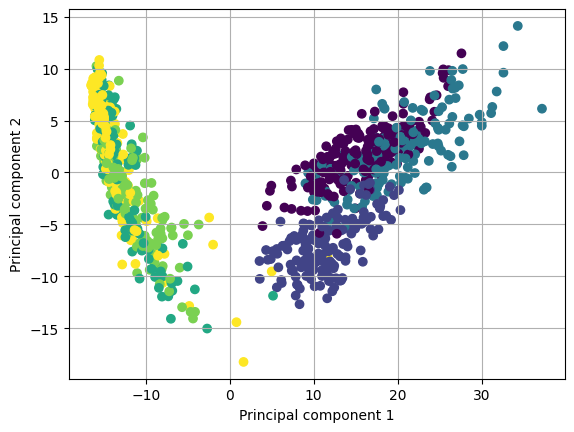

In [12]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

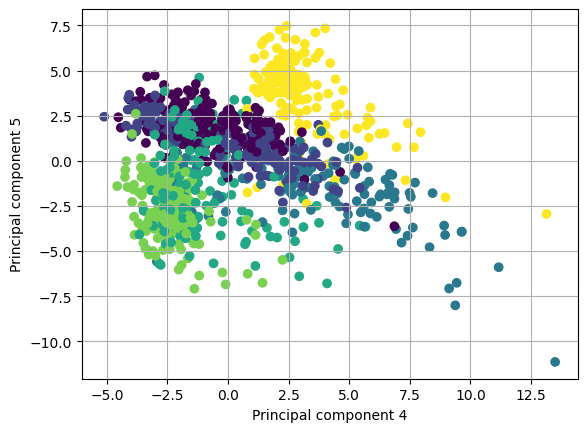

In [13]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [14]:
!pip install ucimlrepo

In [15]:
import ucimlrepo as uci

In [ ]:
# dataset = uci.fetch_ucirepo(id=186)

# print(dataset.metadata.name, '\n')
# print(dataset.metadata.abstract, '\n')
# print(dataset.metadata.additional_info.summary, '\n')

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [9]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [10]:
from sklearn.model_selection import train_test_split

X_train_pca_new, X_val_pca , y_train_new, y_val = train_test_split(X_train_pca, y_train, train_size=0.8, random_state=42)

X_train_pca_new.shape, X_val_pca.shape, X_test_pca.shape

((5881, 179), (1471, 179), (2947, 179))

In [19]:
# YOUR CODE HERE

# Example: https://rpubs.com/burakh/har_xgb

model = CatBoostClassifier(iterations=250, learning_rate=0.1, eval_metric="Accuracy", depth=10, random_seed=42)
model.fit(X_train_pca_new, y_train_new, eval_set=(X_val_pca, y_val), plot=True, logging_level='Silent')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8015644	test: 0.7362339	best: 0.7362339 (0)	total: 293ms	remaining: 1m 12s
1:	learn: 0.8282605	test: 0.7777022	best: 0.7777022 (1)	total: 510ms	remaining: 1m 3s
2:	learn: 0.8347220	test: 0.7838205	best: 0.7838205 (2)	total: 733ms	remaining: 1m
3:	learn: 0.8541064	test: 0.8062542	best: 0.8062542 (3)	total: 1s	remaining: 1m 1s
4:	learn: 0.8644788	test: 0.8096533	best: 0.8096533 (4)	total: 1.28s	remaining: 1m 2s
5:	learn: 0.8649889	test: 0.8171312	best: 0.8171312 (5)	total: 1.54s	remaining: 1m 2s
6:	learn: 0.8734909	test: 0.8327668	best: 0.8327668 (6)	total: 1.75s	remaining: 1m
7:	learn: 0.8797823	test: 0.8402447	best: 0.8402447 (7)	total: 1.97s	remaining: 59.5s
8:	learn: 0.8860738	test: 0.8477226	best: 0.8477226 (8)	total: 2.19s	remaining: 58.5s
9:	learn: 0.8911750	test: 0.8429640	best: 0.8477226 (8)	total: 2.4s	remaining: 57.7s
10:	learn: 0.8921952	test: 0.8443236	best: 0.8477226 (8)	total: 2.61s	remaining: 56.8s
11:	learn: 0.8974664	test: 0.8470428	best: 0.8477226 (8)	total

In [23]:
def print_feature_importance(model: CatBoostClassifier):
    feature_importances = model.get_feature_importance()
    feature_names = [i for i in range(y_train.shape[0])]
    i = 0
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
        i+=1
        print("{}: {}".format(name, score))
        if i==10: break

In [24]:
train_pool = Pool(X_train_pca_new, y_train_new)
model = CatBoostClassifier(iterations=500, learning_rate=0.1, l2_leaf_reg=5, eval_metric="Accuracy", depth=5, random_seed=42)
model.fit(train_pool, eval_set=(X_val_pca, y_val), plot=True, logging_level="Silent")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
print_feature_importance(model)

0: 37.67610068787888
3: 12.12825590662136
4: 9.668919772053567
1: 5.823268648348435
7: 3.076430284576991
2: 2.3788503986723746
5: 1.7313342225397497
23: 1.7164913051337165
9: 1.3823011446170972
12: 1.1359077094112633


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
# YOUR CODE HERE
!pip install hyperopt

In [26]:
import hyperopt

def opt_objective(params):
    model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        iterations=500,
        eval_metric=metrics.Accuracy(),
        loss_function='MultiClass',
        random_seed=42,
        verbose=False,
    )
    
    cv_data = cv(
        Pool(X_train_pca, y_train),
        model.get_params(),
        logging_level='Silent',
    )
    
    best_acc = np.max(cv_data['test-Accuracy-mean'])
    return 1 - best_acc

In [ ]:
params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 1, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.quniform('depth', 3, 15, 3),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    opt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=5,
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 5/5 [02:37<00:00, 31.47s/trial, best loss: 0.03305025109554427]


In [54]:
print(best)

{'depth': 15.0, 'l2_leaf_reg': 2.0, 'learning_rate': 0.4070140484125036}


In [11]:
model = CatBoostClassifier(
    l2_leaf_reg=2.0,
    learning_rate=0.4070140484125036,
    depth=7,
    iterations=500,
    eval_metric=metrics.Accuracy(),
    random_seed=42,
    verbose=False,
    od_type="Iter",
    od_wait=50,
)
model.fit(X_train_pca_new, y_train_new, eval_set=(X_val_pca, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, model.predict(X_test_pca))

0.9324737020699015

In [13]:
model.save_model('model.dump')
model = CatBoostClassifier()
model.load_model("model.dump")

### Conclusion

Please, write down your thoughts on the experiment results:

...

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [15]:
import shap  # noqa: F401

# YOUR CODE HERE

expl = shap.TreeExplainer(model)
shap_values = expl(X_test_pca)


In [17]:
shap_values.shape, X_test_pca.shape

((2947, 179, 6), (2947, 179))

SHAP Summary for Class 0


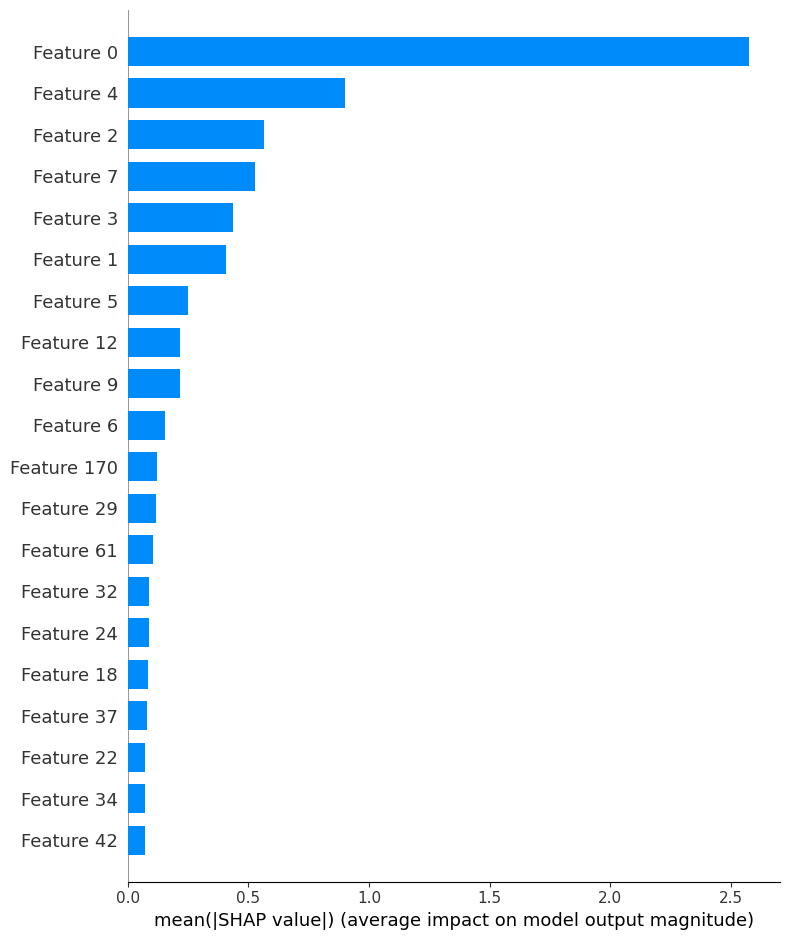

SHAP Summary for Class 1


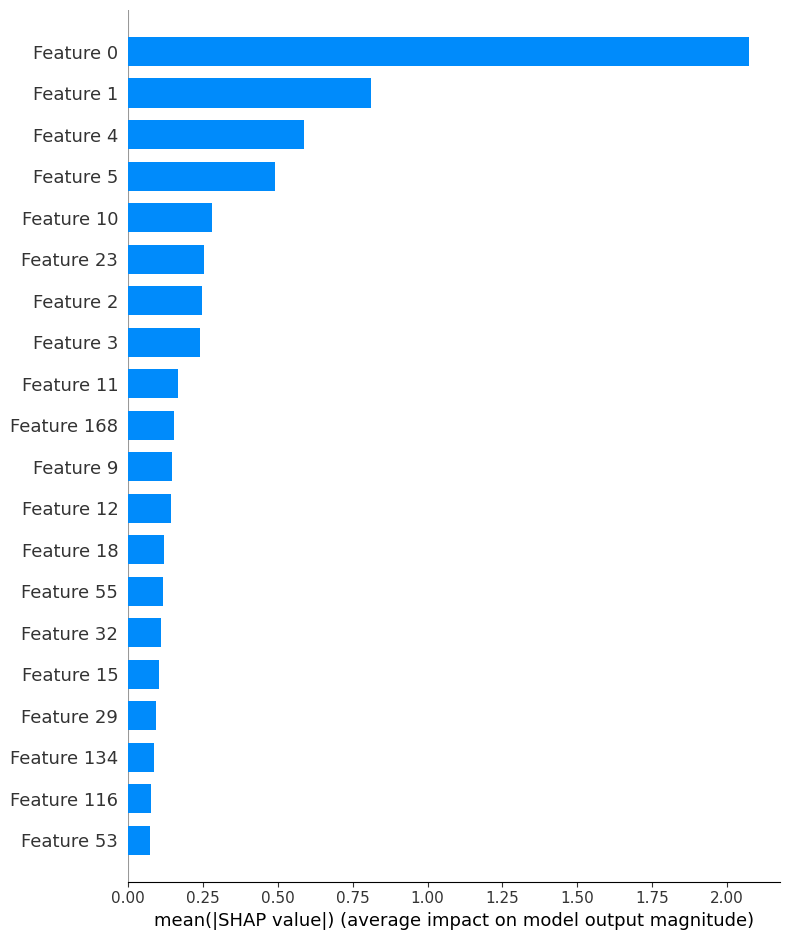

SHAP Summary for Class 2


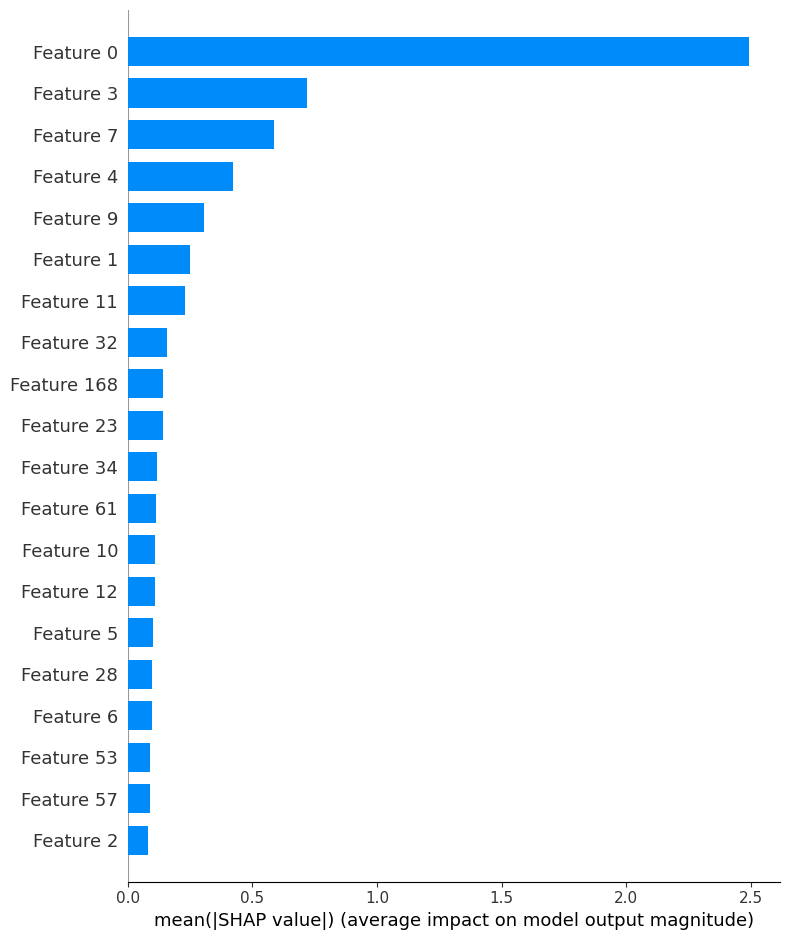

SHAP Summary for Class 3


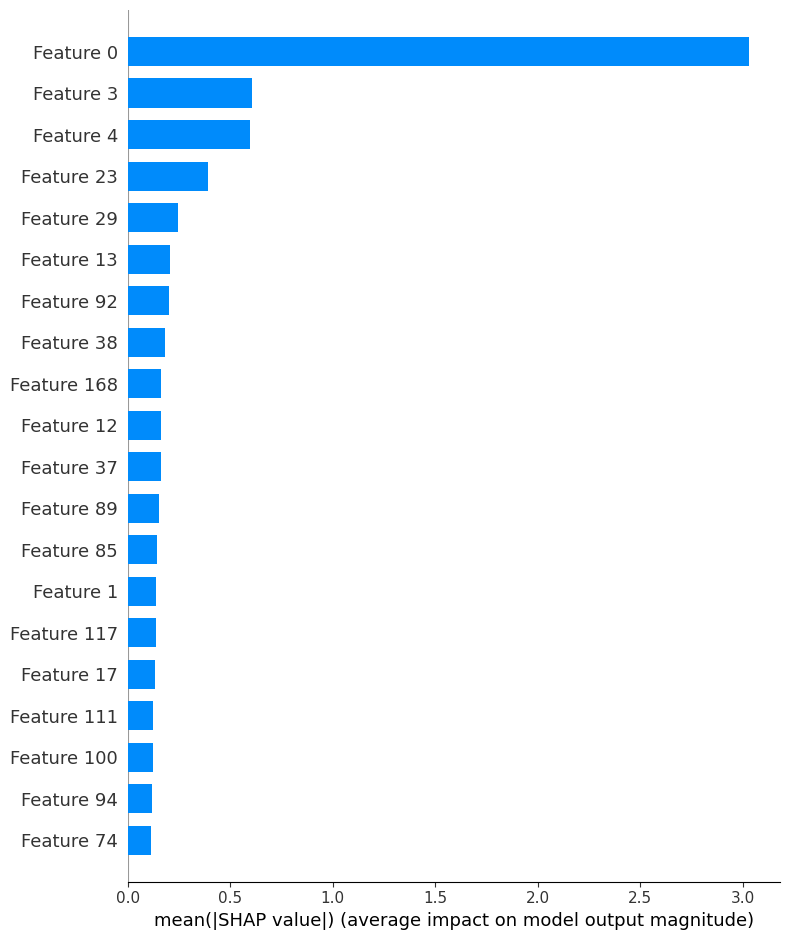

SHAP Summary for Class 4


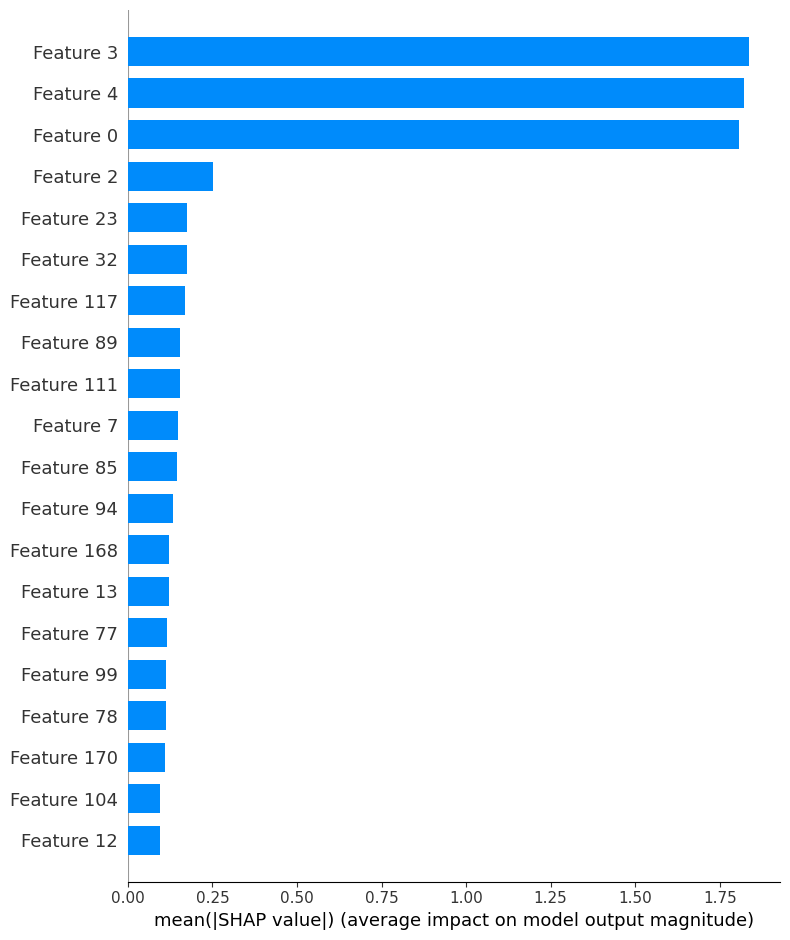

SHAP Summary for Class 5


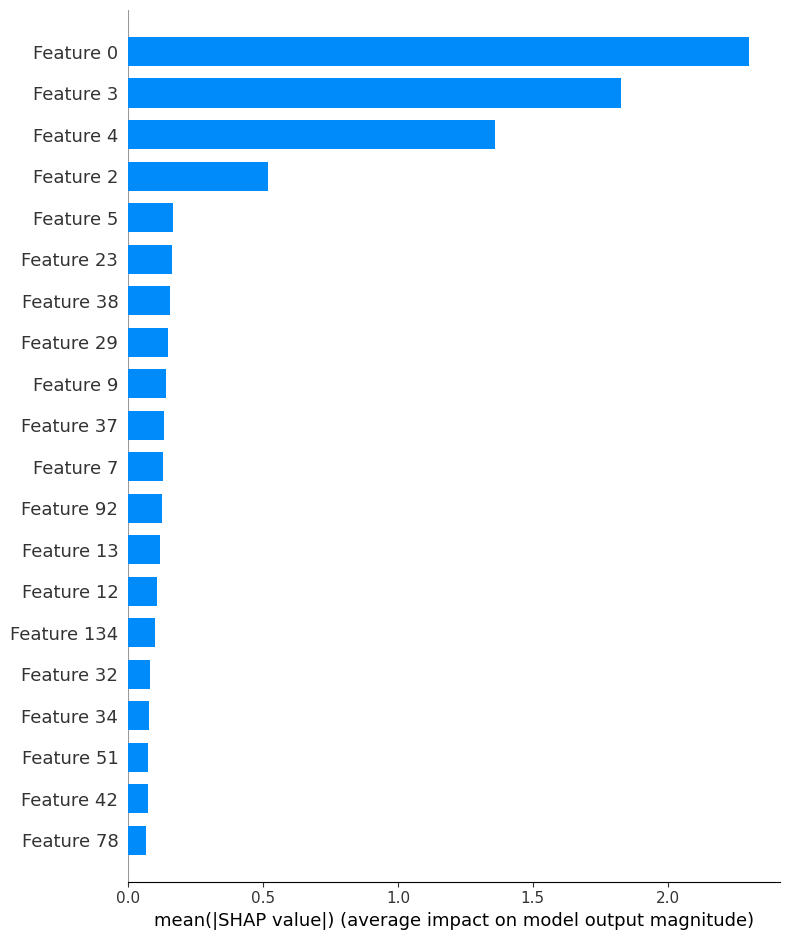

In [20]:
for class_idx in range(6):
    print(f"SHAP Summary for Class {class_idx}")
    shap.summary_plot(shap_values[:, :, class_idx], X_test_pca, plot_type="bar")

### Conclusion

Your thoughts about the plots and model behaviour:

...